In [1]:
import os
os.chdir(os.path.expanduser("~/phd/phd_nbeats_with_feature_vector"))

import neurokit2 as nk
import numpy as np
import sklearn as sk
from challenge import *
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import math


In [2]:
def clean_labels(header):
    logger.debug(f"Clean label for header file: {header}")
    classes_from_header = get_labels(header)
    
    logger.debug(f"Classes found in header: {classes_from_header}")
    if '733534002' in classes_from_header:
        classes_from_header[classes_from_header.index('733534002')] = '164909002'
        classes_from_header = list(set(classes_from_header))
    if '713427006' in classes_from_header:
        classes_from_header[classes_from_header.index('713427006')] = '59118001'
        classes_from_header = list(set(classes_from_header))
    if '63593006' in classes_from_header:
        classes_from_header[classes_from_header.index('63593006')] = '284470004'
        classes_from_header = list(set(classes_from_header))
    if '427172004' in classes_from_header:
        classes_from_header[classes_from_header.index('427172004')] = '17338001'
        classes_from_header = list(set(classes_from_header))

    return classes_from_header


In [3]:
# Constants
data_directory="../data/physionet.org/files/challenge-2021/1.0.3/training/georgia/g1"
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

xls = pd.ExcelFile('label_mappings.xlsx')
df = pd.read_excel(xls, 'G12EC')

df_labels_to_class_list=df[['SNOMED code','Diagnosis in the dataset']].set_index('SNOMED code').apply(lambda row: {row.name: row.values.tolist()[0]}, axis=1).tolist()
labels_to_class= reduce(lambda a, b: a|b, df_labels_to_class_list)

In [4]:
header_files, recording_files = find_challenge_files(data_directory)
num_recordings = len(header_files)
    
print(f"Finished loading: {num_recordings} files")
recording_index = 15

header = load_header(header_files[recording_index])
current_labels= clean_labels(header)
print(current_labels)
current_abbreviations=[labels_to_class[int(label)] for label in current_labels]
print(current_abbreviations)

recording = np.array(load_recording(recording_files[recording_index]), dtype=np.float32)
recording_full = get_leads_values(header, recording, leads)


Finished loading: 999 files
['426783006']
['sinus rhythm']


60.050649451221126

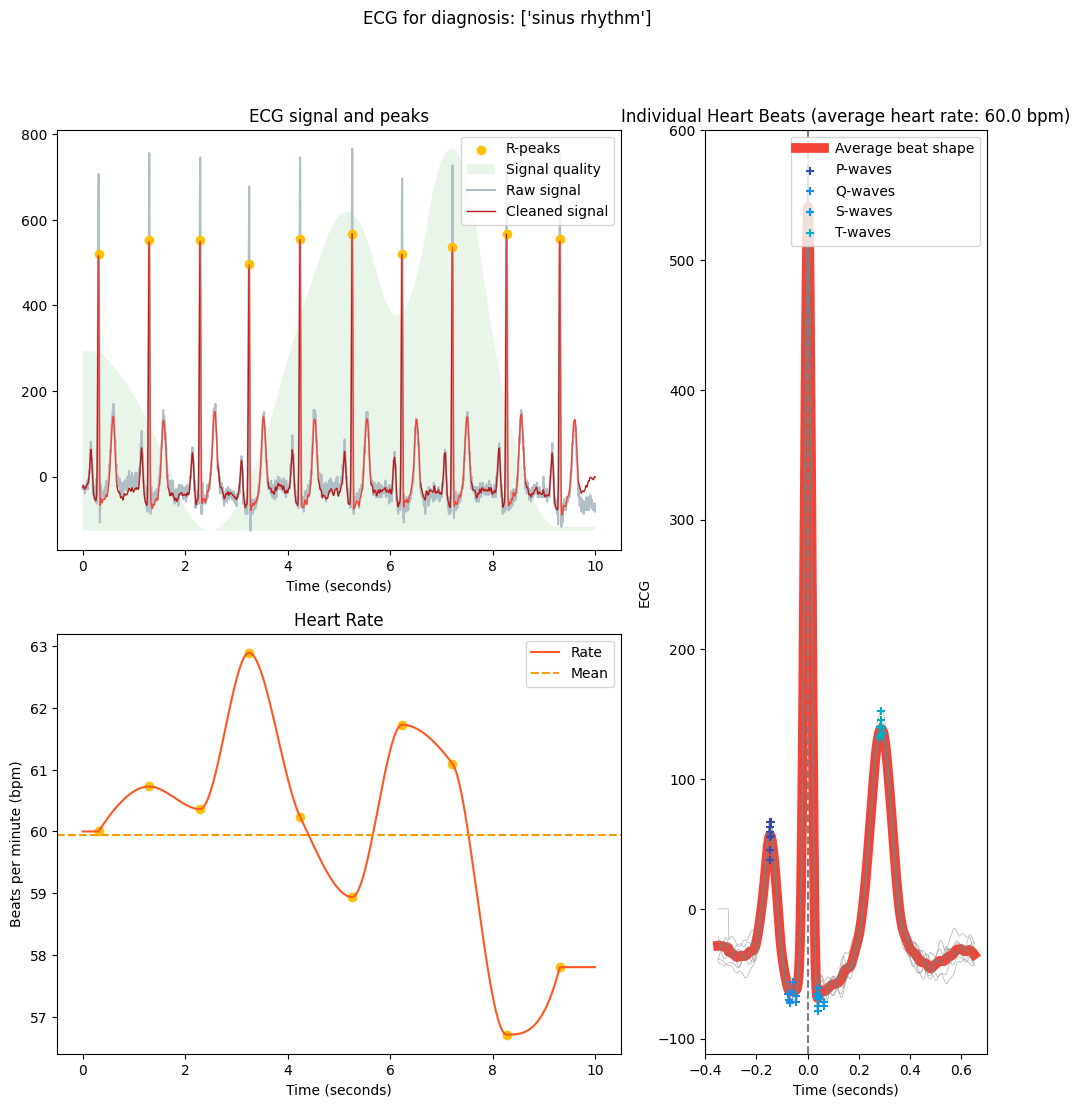

In [5]:
signals, info = nk.ecg_process(recording[0], sampling_rate=500)

# Visualise the processing
nk.ecg_plot(signals, info)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")

bpm=np.mean(nk.ecg_rate(signals, sampling_rate=500))
bpm


In [6]:
def leading_rythm(bpm):
    if(bpm < 50):
       return -1
    elif (50< bpm < 100):
        return 0
    else:
        return 1

leading_rythm(bpm)

0

In [24]:
def get_wavelet_orientation(onset, peak, offset):
    if peak > (onset+offset)/2 :
        return 1
    else:
        return -1

#R->L (correct) return 1, L->R (incorrect) return -1 LEAD I
def get_right_left_activation_leadI(p_complexes):
    return np.mean([get_wavelet_orientation(*px) for px in p_complexes])

#Correct sinus return 1 (pwave positive), Extra sinus orign return -1 (pwave negative) on lead II or lead III or aVF
def get_vertical_orientation(p_complexes):
    return np.mean([get_wavelet_orientation(*px) for px in p_complexes])

def get_p_complex(signals, info):
    num_peaks = len(info['ECG_P_Peaks'])
    result=[]
    for i in range(num_peaks):
        p_on = info['ECG_P_Onsets'][i]
        p = info['ECG_P_Peaks'][i]
        p_off = info['ECG_P_Offsets'][i]

        if np.isnan([p_on, p, p_off]).any():
            continue

        p_complex = [signals.iloc[p_on]['ECG_Raw'], signals.iloc[p]['ECG_Raw'], signals.iloc[p_off]['ECG_Raw']]
        
        if np.isnan(p_complex).any():
            continue
        else:
            result.append(p_complex)
    return result
    
#          | R   |  L
#---------------------
# top-down | 1 1 | 1 -1
#---------------------
# down-top | -1 1 | -1 -1
def get_rhythm_origin(signalsI, infoI, signalsII, infoII):
    I_pcomplexes = get_p_complex(signalsI, infoI)
    II_pcomplexes = get_p_complex(signalsII, infoII)

    return get_vertical_orientation(II_pcomplexes), get_right_left_activation_leadI(I_pcomplexes)
    



#https://www.cmj.hr/1999/40/1/9933900.htm
def get_heart_axis(leadI_QRS, leadaVF_QRS):
    results=[]
    for i in range(len(leadI_QRS)):
        aVF_QRS=leadaVF_QRS[i]
        I_QRS=leadI_QRS[i]
        altitudeAVF=sum(aVF_QRS)
        altitudeI=sum(I_QRS)
        results.append(math.degrees(math.atan2((2*altitudeAVF),(math.sqrt(3)*altitudeI))))
    return results

def get_QRS_from_lead(signals, info):
    num_peaks = len(info['ECG_R_Peaks'])
    result = []
    for i in range(num_peaks):
        Q = info['ECG_Q_Peaks'][i]
        R = info['ECG_R_Peaks'][i]
        S = info['ECG_S_Peaks'][i]

        QRS_ts= [Q, R, S]
        if np.isnan(QRS_ts).any():
            continue

        QRS = [signals.iloc[Q]['ECG_Raw'], signals.iloc[R]['ECG_Raw'], signals.iloc[S]['ECG_Raw']]
        if np.isnan(QRS).any():
            continue
        else:
            result.append(QRS)
    
    return result
        


In [25]:
signals_I, info_I = nk.ecg_process(recording[0], sampling_rate=500)
signals_II, info_II = nk.ecg_process(recording[1], sampling_rate=500)
signals_aVF, info_aVF = nk.ecg_process(recording[5], sampling_rate=500)

QRS_I = get_QRS_from_lead(signals_I, info_I)
QRS_aVF = get_QRS_from_lead(signals_aVF, info_aVF)



print(QRS_I)
print(QRS_aVF)
print(get_heart_axis(QRS_I, QRS_aVF))
print(get_rhythm_origin(signals_I, info_I, signals_II, info_II))

[[-58.0, 678.0, -48.0], [-73.0, 746.0, -63.0], [-63.0, 736.0, -73.0], [-78.0, 629.0, -78.0], [-63.0, 746.0, -58.0], [-53.0, 766.0, -63.0], [-87.0, 678.0, -73.0], [-87.0, 678.0, -63.0], [-82.0, 736.0, -73.0]]
[[-65.0, 866.0, -41.0], [-29.0, 763.0, -29.0], [-219.0, 695.0, -134.0], [-226.0, 868.0, -158.0], [-187.0, 744.0, -36.0], [-100.0, 695.0, 17.0], [-21.0, 973.0, -26.0], [-70.0, 695.0, -61.0], [-90.0, 707.0, -95.0]]
[56.90376898224057, 53.15479077924754, 33.35208523705128, 49.757326231528296, 43.907045380485656, 47.39220601826183, 64.15210896366779, 50.966686621913425, 46.05279827575479]
(1.0, 1.0)
